# Chapter 4: Noise

#### Ngo Trong Hieu - ID: 15943

In [2]:
import os
if not os.path.exists('thinkdsp.py'):
    !wget https://github.com/cpulover/signal-processing/blob/master/thinkdsp.py

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from thinkdsp import decorate

### Exercise 4.1

``A Soft Murmur'' is a web site that plays a mixture of natural noise sources, including rain, waves, wind, etc. At http://asoftmurmur.com/about/ you can find their list of recordings, most of which are at http://freesound.org.

Download a few of these files and compute the spectrum of each signal. Does the power spectrum look like white noise, pink noise, or Brownian noise? How does the spectrum vary over time?

In [4]:
if not os.path.exists('fireplace.wav'):
    !wget https://github.com/cpulover/signal-processing/blob/master/fireplace.wav

In [5]:
from thinkdsp import read_wave
wave = read_wave('fireplace.wav')
wave.make_audio()

In [9]:
segment = wave.segment(start=1, duration=0.5)
segment.make_audio()

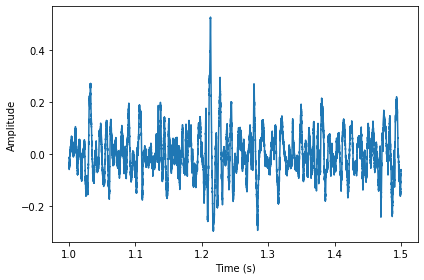

In [11]:
segment.plot()
decorate(xlabel='Time (s)',
         ylabel='Amplitude')

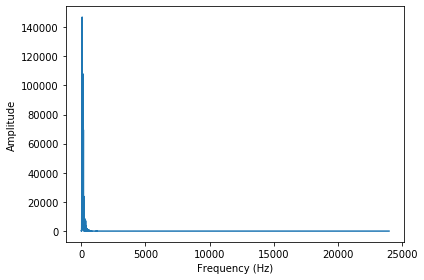

In [14]:
spectrum = segment.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Amplitude')

Most of the energy is at low frequencies, we can't even see the high frequencies.
We can get a better view by plotting the power spectrum on a log-log scale:

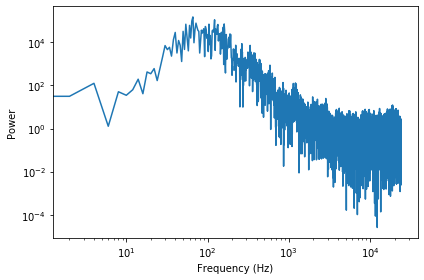

In [21]:
spectrum.plot_power()
loglog = dict(xscale='log', yscale='log')
decorate(xlabel='Frequency (Hz)',
         ylabel='Power',
         **loglog)

The power seems to be increasing till f = 10^2 and dropping off linearly above that. We can find out the slope of this line:

In [20]:
result = spectrum.estimate_slope()
result.slope

-1.0275167756424743

 The slope of this line is approximately -1, which indicates that P = K / f, for some constant $K$. So this sound is likely a pink noise.

### Exercise 4.2

In a noise signal, the mixture of frequencies changes over time. In the long run, we expect the power at all frequencies to be equal, but in any sample, the power at each frequency is random.

To estimate the long-term average power at each frequency, we can break a long signal into segments, compute the power spectrum for each segment, and then compute the average across the segments. You can read more about this algorithm at http://en.wikipedia.org/wiki/Bartlett's_method.

Implement Bartlett's method and use it to estimate the power spectrum for a noise wave. Hint: look at the implementation of make_spectrogram.

In [22]:
from thinkdsp import Spectrum

def bartlett_method(wave, seg_length=512, win_flag=True):
    """Estimates the power spectrum of a noise wave.
    
    wave: Wave
    seg_length: segment length
    """
    # make a spectrogram and extract the spectrums
    spectro = wave.make_spectrogram(seg_length, win_flag)
    spectrums = spectro.spec_map.values()
    
    # extract the power array from each spectrum
    psds = [spectrum.power for spectrum in spectrums]
    
    # compute the root mean power (which is like an amplitude)
    hs = np.sqrt(sum(psds) / len(psds))
    fs = next(iter(spectrums)).fs
    
    # make a Spectrum with the mean amplitudes
    spectrum = Spectrum(hs, fs, wave.framerate)
    return spectrum

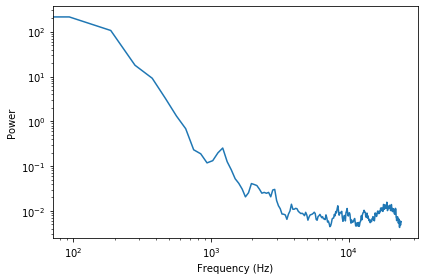

In [23]:
psd = bartlett_method(segment)
psd.plot_power()
decorate(xlabel='Frequency (Hz)', 
         ylabel='Power', 
         **loglog)


Now we can see the relationship between power and frequency in more details. The line is not perfect linear but the trends are similar for different segments.

### Exercise 4.3

At coindesk you can download the daily price of a BitCoin as a CSV file. Read this file and compute the spectrum of BitCoin prices as a function of time. Does it resemble white, pink, or Brownian noise?

In [42]:
if not os.path.exists('bitcoin-price.csv'):
    !wget https://github.com/cpulover/signal-processing/blob/master/bitcoin-price.csv

In [43]:
import pandas as pd
df = pd.read_csv('bitcoin-price.csv', parse_dates=[0])
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2020-05-22,9194.6,9058.2,9253.5,8952.1,938.86K,1.50%
1,2020-05-21,9059.0,9511.6,9567.1,8833.6,1.41M,-4.76%
2,2020-05-20,9512.3,9773.0,9829.3,9368.4,1.15M,-2.67%
3,2020-05-19,9773.3,9730.8,9883.9,9498.7,1.16M,0.00
4,2020-05-18,9730.7,9678.4,9930.2,9524.4,1.18M,0.55%
...,...,...,...,...,...,...,...
595,2018-10-05,6639.1,6584.2,6682.3,6537.6,9.34M,0.83%
596,2018-10-04,6584.2,6509.2,6653.0,6487.8,9.31M,1.17%
597,2018-10-03,6507.8,6549.9,6563.5,6429.6,9.21M,-0.64%
598,2018-10-02,6549.9,6608.2,6645.7,6034.9,9.34M,-0.88%


The data is collected from 10/2018 to 05/2020. We will analyse Price column (USD)

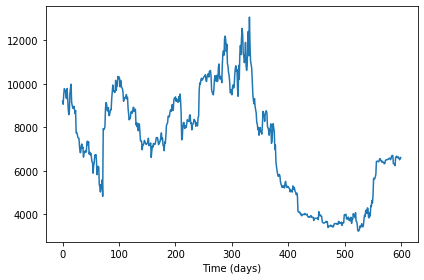

In [49]:
from thinkdsp import Wave
from locale import atof, setlocale, LC_NUMERIC
setlocale(LC_NUMERIC, '')
ys = df['Price']
ts = df.index
wave = Wave(ys, ts, framerate=10)
wave.plot()
decorate(xlabel='Time (days)')

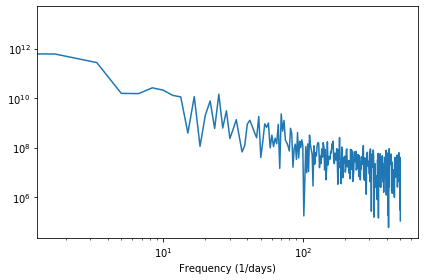

In [45]:
spectrum = wave.make_spectrum()
spectrum.plot_power()
decorate(xlabel='Frequency (1/days)', **loglog)

In [50]:
spectrum.estimate_slope()[0]

-1.7252016118181035

The slope is 1.7, between 0 and 2. So it resembles a pink noise.

### Exercise 4.4

A Geiger counter is a device that detects radiation. When an ionizing particle strikes the detector, it outputs a surge of current. The total output at a point in time can be modeled as uncorrelated Poisson (UP) noise, where each sample is a random quantity from a Poisson distribution, which corresponds to the number of particles detected during an interval.

Write a class called UncorrelatedPoissonNoise that inherits from _Noise and provides evaluate. It should use np.random.poisson to generate random values from a Poisson distribution. The parameter of this function, lam, is the average number of particles during each interval. You can use the attribute amp to specify lam. For example, if the framerate is 10 kHz and amp is 0.001, we expect about 10 “clicks” per second.

Generate about a second of UP noise and listen to it. For low values of amp, like 0.001, it should sound like a Geiger counter. For higher values it should sound like white noise. Compute and plot the power spectrum to see whether it looks like white noise.

In [54]:
from thinkdsp import Noise

class UncorrelatedPoissonNoise(Noise):
    """Represents uncorrelated Poisson noise."""

    def evaluate(self, ts):
        """Evaluates the signal at the given times.

        ts: float array of times
        
        returns: float wave array
        """
        ys = np.random.poisson(self.amp, len(ts))
        return ys

Generate an UP noise of low amp:

In [102]:
amp_low = 0.001
framerate = 10000
duration = 1

signal = UncorrelatedPoissonNoise(amp=amp_low)
wave = signal.make_wave(duration=duration, framerate=framerate)

For low values of amp, it sounds like a Geiger counter:

In [103]:
wave.make_audio()

Generate an UP noise of high amp:

In [108]:
amp_high = 1

signal = UncorrelatedPoissonNoise(amp=amp_high)
wave = signal.make_wave(duration=duration, framerate=framerate)

For higher values of amp, it sounds like a white noise:

In [105]:
wave.make_audio()

In [ ]:
The power spectrum of this sound suggests it is a white noise:

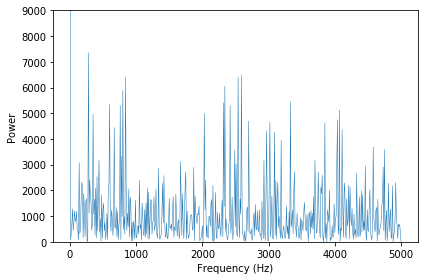

In [136]:
import matplotlib.pyplot as plt 
segment = wave.segment(duration=0.1)
spectrum = segment.make_spectrum()
spectrum.plot_power(linewidth=0.5)
plt.ylim(0, 9000)

decorate(xlabel='Frequency (Hz)',
         ylabel='Power')

This noise has the same power at all frequencies, on average, which we can confirm by looking at the normalized cumulative sum of power:

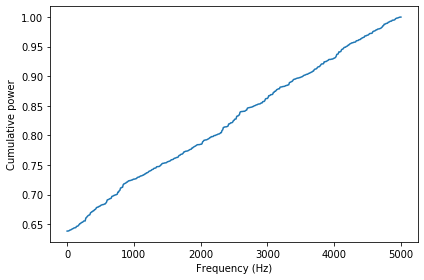

In [117]:
integ = spectrum.make_integrated_spectrum()
integ.plot_power()
decorate(xlabel='Frequency (Hz)',
         ylabel='Cumulative power')

A straight line in this figure indicates that noise has equal power at all frequencies, on average.This is a property of a white noise.

### Exercise 4.5

The algorithm in this chapter for generating pink noise is conceptually simple but computationally expensive. There are more effcient alternatives, like the Voss-McCartney algorithm. Research this method, implement it, compute the spectrum of the result, and confirm that it has the desired relationship between power and frequency.

In [138]:
def voss(nrows, ncols=16):
    """Generates pink noise using the Voss-McCartney algorithm.
    
    nrows: number of values to generate
    rcols: number of random sources to add
    
    returns: NumPy array
    """
    array = np.empty((nrows, ncols))
    array.fill(np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # the total number of changes is nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)

    df = pd.DataFrame(array)
    df.fillna(method='ffill', axis=0, inplace=True)
    total = df.sum(axis=1)

    return total.values

Compute power spectrum of wave of 10000 values

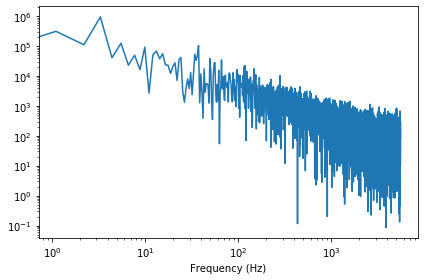

In [141]:
ys = voss(10000)
wave = Wave(ys)
wave.unbias()
wave.normalize()
spectrum = wave.make_spectrum()
spectrum.hs[0] = 0
spectrum.plot_power()
decorate(xlabel='Frequency (Hz)',
         **loglog)

In [142]:
spectrum.estimate_slope().slope

-1.031381321161053

The slope is about 1, which indicates a pink noise.